# Natural Language Processing with Disaster Tweets

In [1]:
import numpy as np 
import pandas as pd 
import re
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer ,CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression 
from wordcloud import WordCloud 
from sklearn.naive_bayes import GaussianNB ,MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [2]:
test_df=pd.read_csv("test.csv")
train_df=pd.read_csv("train.csv")
submission =pd.read_csv("submission.csv")

### Quick EDA

In [3]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
train_df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [6]:
train_df['keyword'].unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

In [7]:
train_df['location'].unique()

array([nan, 'Birmingham', 'Est. September 2012 - Bristol', ...,
       'Vancouver, Canada', 'London ', 'Lincoln'], dtype=object)

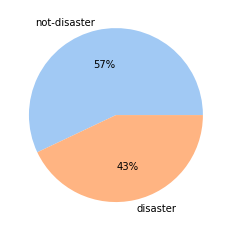

In [8]:
data = [train_df.groupby(['target']).count()['id'][0], train_df.groupby(['target']).count()['id'][1]]
colors = sns.color_palette('pastel')
labels = ['not-disaster', 'disaster']
plt.pie(data, colors = colors,labels=labels,autopct = '%0.0f%%')
plt.show()

In [9]:
print(train_df.isna().sum())

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


In [10]:
print('No.of.Unique Keyword : ',len(train_df.keyword.unique()))
train_df.keyword.value_counts(ascending=False)

No.of.Unique Keyword :  222


fatalities               45
deluge                   42
armageddon               42
damage                   41
body%20bags              41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [11]:
train_df.duplicated().sum()

0

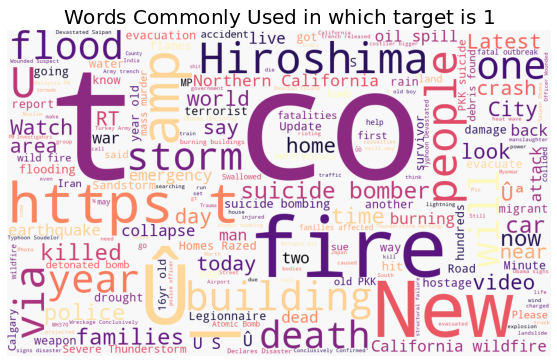

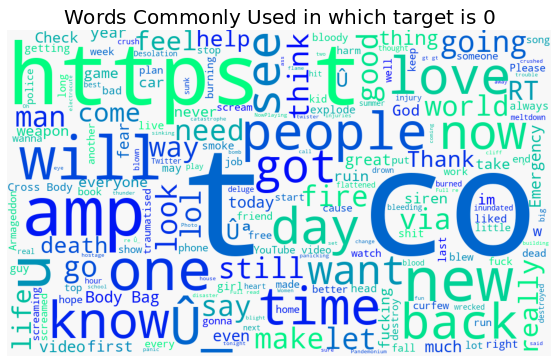

In [12]:
#WordCloud for the Sentiments
for label, cmap in zip([1,0],
                       ['magma','winter']):
    text = train_df.query('target == @label')['text'].str.cat(sep=' ')
    plt.figure(figsize=(10, 6))
    wc = WordCloud(width=1000, height=600, background_color="#f8f8f8", colormap=cmap)
    wc.generate_from_text(text)
    plt.imshow(wc)
    plt.axis("off")
    plt.title(f"Words Commonly Used in which target is ${label}$", size=20)
    plt.show()

In [13]:
# Make A List Of All Words in DataFrame
words = []
for i in train_df.text:
    words.extend(i.split())
print('unique words : ',len(set(words)))
print('total words :',len(words))

unique words :  31924
total words : 113461


In [14]:
# Most Common 20 Words
Counter(words).most_common(20)

[('the', 2575),
 ('a', 1845),
 ('to', 1805),
 ('in', 1757),
 ('of', 1722),
 ('and', 1302),
 ('I', 1197),
 ('for', 820),
 ('is', 814),
 ('on', 773),
 ('-', 763),
 ('you', 632),
 ('The', 552),
 ('my', 549),
 ('with', 508),
 ('that', 492),
 ('at', 485),
 ('by', 469),
 ('it', 433),
 ('from', 372)]

### Data Pre-Processing

In [15]:
def to_lower_case(text):
    text = [' '.join(tx.lower() for tx in word.split()) for word in text]
    return text

In [16]:
train_df.replace(regex={'%20': ' '},inplace=True)

Replacing chat messages to real message

In [17]:
train_df.replace(regex={'AFAIK':'As Far As I Know',
' AFK ':' Away From Keyboard ',
' ASAP ':' As Soon As Possible ',
' ATK ':' At The Keyboard ',
' ATM ':' At The Moment ',
' A3 ':' Anytime, Anywhere, Anyplace ',
' BAK ':' Back At Keyboard ',
' BBL ':' Be Back Later ',
' BBS ':' Be Back Soon ',
' BFN ':' Bye For Now ',
' B4N ':' Bye For Now ',
' BRB ':' Be Right Back ',
' BRT ':' Be Right There ',
' BTW ':' By The Way ',
' B4 ':' Before ',
' B4N ':' Bye For Now ',
' CU ':' See You ',
' CUL8R ':' See You Later ',
' CYA ':' See You ',
' FAQ ':' Frequently Asked Questions ',
' FC ':' Fingers Crossed ',
' FWIW ':" For What It's Worth ",
' FYI ':' For Your Information ',
' GAL ':' Get A Life ',
' GG ':' Good Game ',
' GN ':' Good Night ',
' GMTA ':' Great Minds Think Alike ',
' GR8 ':" Great! ",
' G9 ':" Genius ",
' IC ':" I See ",
' ICQ ':" I Seek you ",
' ILU ':" I Love You ",
' IMHO ':" In My Honest ",
' IMO ':" In My Opinion ",
' IOW ':" In Other Words ",
' IRL ':" In Real Life ",
' KISS ':" Keep It Simple, Stupid ",
' LDR ':" Long Distance Relationship ",
' LMAO ':" Laugh My Ass ",
' LOL ':" Laughing Out Loud ",
' LTNS ':" Long Time No See ",
' L8R ':" Later ",
' MTE ':" My Thoughts Exactly ",
' M8 ':" Mate ",
' NRN ':" No Reply Necessary ",
' OIC ':" Oh I See ",
' PITA ':" Pain In The Ass ",
' PRT ':" Party ",
' PRW ':" Parents Are Watching ",
' ROFL ':" Rolling On The Floor Laughing ",
' ROFLOL ':" Rolling On The Floor Laughing Out Loud ",
' ROTFLMAO ':" Rolling On The Floor Laughing My Ass ",
' SK8 ':" Skate ",
' STATS ':" Your sex and age ",
' ASL ':" Age, Sex, Location ",
' THX ':" Thank You ",
' TTFN ':" Ta-Ta For Now! ",
' TTYL ':" Talk To You Later ",
' U ':" You ",
' U2 ':" You Too",
' U4E ':" Yours For Ever ",
' WB ':" Welcome Back ",
' WTF ':" What The Fuck ",
' WTG ':" Way To Go! ",
' WUF ':" Where Are You From? ",
' W8 ':" Wait... ",},inplace=True)

In [18]:
train_df.replace(regex={r'https?://\S+': ' ',r'<.*?>':' ',r'\d+':' ',r'#\w+':' ','[^a-zA-Z]': ' ',r'http\S+': ' '},inplace=True)

In [19]:
#removing stop words
def drop_stop_words(tweets):
    stop_words = set(stopwords.words('english'))
    tweets     = [' '.join(word for word in word_tokenize(tweet) if word not in stop_words) for tweet in tweets]
    return tweets

In [20]:
#removing url
def drop_url(text):
    url = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    tweets = [' '.join([re.sub(url,' ',tw) for tw in tweet.split()]) for tweet in text]  
    return tweets

In [21]:
def clean_spaces(tweets):
    tweets = [" ".join(word_tokenize(tweet)) for tweet in tweets]
    return tweets

In [22]:
def get_clean_data(target):
    x_clean = to_lower_case(train[train["target"] == target]["text"])
    x_clean = drop_retweet(x_clean)
    x_clean = drop_url(x_clean)
    x_clean = lemtize_tweets(x_clean)
    x_clean = drop_stop_words(x_clean)
    x_clean = clean_spaces(x_clean)
    return x_clean

In [23]:
def lemtize_tweets(tweets):
    lemmatizer = WordNetLemmatizer() 
    tweets = [' '.join(lemmatizer.lemmatize(word) for word in word_tokenize(tweet)   ) for tweet in tweets]
    return tweets

In [24]:
to_lower_pipe     = FunctionTransformer(to_lower_case)

drop_links_pipe      = FunctionTransformer(drop_url)

lematize_pipe        = FunctionTransformer(lemtize_tweets)

clean_spaces_pipe    = FunctionTransformer(clean_spaces)

drop_stop_words_pipe = FunctionTransformer(drop_stop_words)

In [25]:
def TaE_pipeline(pipe):
    # Create Pipe
    pipeline = Pipeline(pipe)
    
    # Split Data into train and test
    x =train_df.text.copy()
    y =train_df.target.copy()
    x_train ,x_test ,y_train,y_test =train_test_split(x,y,test_size=0.2,random_state=42)
    
    # Train & Test Pipe
    pipeline.fit(x_train,y_train)
    y_hat =pipeline.predict(x_test)
    print(classification_report(y_test,y_hat))
    return pipeline

In [26]:
model = DecisionTreeClassifier()
pipeline = [('lower',to_lower_pipe),
                     ('urls',drop_links_pipe),
                     ('lematize',lematize_pipe),
                     ('spacs',clean_spaces_pipe),
                     ('tf_idf',TfidfVectorizer()),
                     ('model',model)]
pipeline_dtc = TaE_pipeline(pipeline)

              precision    recall  f1-score   support

           0       0.74      0.77      0.76       874
           1       0.67      0.65      0.66       649

    accuracy                           0.72      1523
   macro avg       0.71      0.71      0.71      1523
weighted avg       0.71      0.72      0.71      1523



In [27]:
model = LogisticRegression()

pipeline = [('lower',to_lower_pipe),
                     ('urls',drop_links_pipe),
                     ('lematize',lematize_pipe),
                     ('spacs',clean_spaces_pipe),
                     ('tf_idf',TfidfVectorizer()),
                     ('model',model)]
pipeline_lor = TaE_pipeline(pipeline)

              precision    recall  f1-score   support

           0       0.81      0.89      0.85       874
           1       0.83      0.71      0.77       649

    accuracy                           0.81      1523
   macro avg       0.82      0.80      0.81      1523
weighted avg       0.82      0.81      0.81      1523



In [28]:
model = SVC()
pipeline = [('lower',to_lower_pipe),
                     ('urls',drop_links_pipe),
                     ('lematize',lematize_pipe),
                     ('spacs',clean_spaces_pipe),
                     ('tf_idf',TfidfVectorizer()),
                     ('model',model)]
pipeline_svc = TaE_pipeline(pipeline)

              precision    recall  f1-score   support

           0       0.80      0.92      0.85       874
           1       0.86      0.68      0.76       649

    accuracy                           0.82      1523
   macro avg       0.83      0.80      0.81      1523
weighted avg       0.82      0.82      0.81      1523



In [29]:
model = MultinomialNB()
pipeline = [('lower',to_lower_pipe),
                     ('urls',drop_links_pipe),
                     ('lematize',lematize_pipe),
                     ('spacs',clean_spaces_pipe),
                     ('tf_idf',TfidfVectorizer()),
                     ('model',model)]
pipeline_mnb = TaE_pipeline(pipeline)

              precision    recall  f1-score   support

           0       0.78      0.91      0.84       874
           1       0.85      0.65      0.74       649

    accuracy                           0.80      1523
   macro avg       0.81      0.78      0.79      1523
weighted avg       0.81      0.80      0.80      1523



In [30]:
model = KNeighborsClassifier()

pipeline = [('lower',to_lower_pipe),
                     ('urls',drop_links_pipe),
                     ('lematize',lematize_pipe),
                     ('spacs',clean_spaces_pipe),
                     ('tf_idf',TfidfVectorizer()),
                     ('model',model)]
pipeline_knn = TaE_pipeline(pipeline)

              precision    recall  f1-score   support

           0       0.78      0.84      0.81       874
           1       0.76      0.69      0.72       649

    accuracy                           0.77      1523
   macro avg       0.77      0.76      0.77      1523
weighted avg       0.77      0.77      0.77      1523



In [31]:
test_df.isna().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [32]:
x = test_df['text']

In [33]:
test_prediction1 = pipeline_svc.predict(x)

In [34]:
test_prediction2 = pipeline_knn.predict(x)

In [35]:
test_prediction3 = pipeline_dtc.predict(x)

In [36]:
test_prediction4 = pipeline_lor.predict(x)

In [37]:
submission = pd.read_csv('submission.csv')
submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [38]:
submission["target"] = test_prediction1
submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [39]:
submission["target"] = test_prediction2
submission.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,1


In [40]:
submission["target"] = test_prediction3
submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [41]:
submission["target"] = test_prediction4
submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [42]:
submission.to_csv('Submission.csv', index=False)

In [43]:
submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1
